
# Visualizing Quantum States in Qiskit 2.x

This notebook covers the core visualization tools for quantum **states** (and related results) in Qiskit 2.x.

**Topics covered**
- `bloch_sphere_concepts`: convert between (θ,φ), |ψ⟩, and (x,y,z)
- `plot_bloch_vector`
- `plot_bloch_multivector`
- `plot_state_qsphere` (with **What is a Qsphere?** explanation)
- `plot_state_hinton`
- `plot_state_city`
- `plot_state_paulivec`
- `plot_histogram`

> Install visualization extras if needed:
> ```bash
> pip install "qiskit[visualization]"
> ```
> Optional simulator sections may use Aer:
> ```bash
> pip install qiskit-aer
> ```


In [1]:

# Setup imports
import numpy as np
from IPython.display import display
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector, DensityMatrix, SparsePauliOp, partial_trace
from qiskit.visualization import (
    plot_bloch_vector,
    plot_bloch_multivector,
    plot_state_qsphere,
    plot_state_hinton,
    plot_state_city,
    plot_state_paulivec,
    plot_histogram,
)



## 0) Bloch sphere concepts

A single-qubit pure state (up to a global phase) is
|ψ⟩ = cos(θ/2)|0⟩ + e^{iφ} sin(θ/2)|1⟩.

Its **Bloch vector** **r = (x, y, z)** is
x = sinθ cosφ,  y = sinθ sinφ,  z = cosθ.

For any state ρ, the components are expectations:
x = ⟨X⟩ = Tr(ρX), y = ⟨Y⟩, z = ⟨Z⟩, with ‖r‖ ≤ 1 (pure: ‖r‖=1).


In [2]:

def bloch_from_statevector(sv: Statevector):
    x = float(np.real(sv.expectation_value(SparsePauliOp('X'))))
    y = float(np.real(sv.expectation_value(SparsePauliOp('Y'))))
    z = float(np.real(sv.expectation_value(SparsePauliOp('Z'))))
    return x, y, z

def state_from_angles(theta: float, phi: float) -> Statevector:
    alpha = np.cos(theta/2)
    beta = np.exp(1j*phi)*np.sin(theta/2)
    return Statevector([alpha, beta])

# Sanity: θ=π/2, φ=π/2 → (0,1,0)
sv_demo = state_from_angles(np.pi/2, np.pi/2)
bloch_from_statevector(sv_demo)


(6.123233995736766e-17, 1.0, 2.220446049250313e-16)


## 1) `plot_bloch_vector` — plot a **single** Bloch vector

- Input: (x, y, z) with ‖r‖ ≤ 1.
- Use when you have Bloch components (from analysis or conversion).

Here **r** denotes the Bloch vector **r = (x, y, z)**.


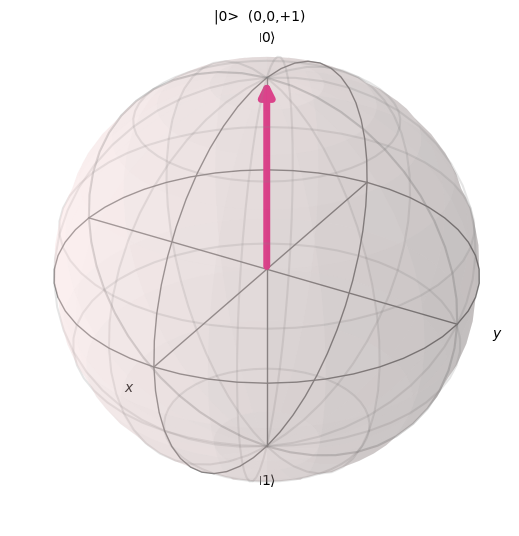

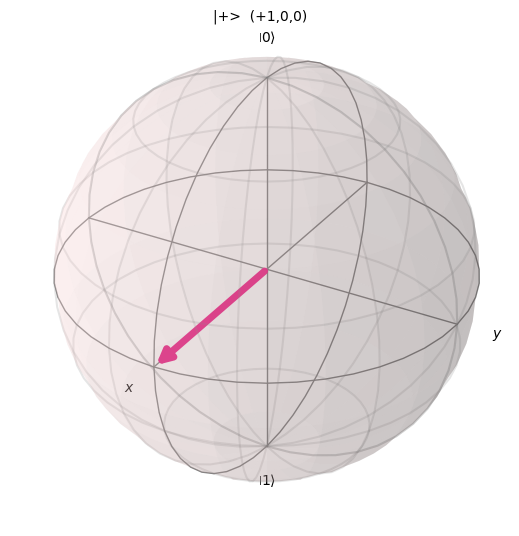

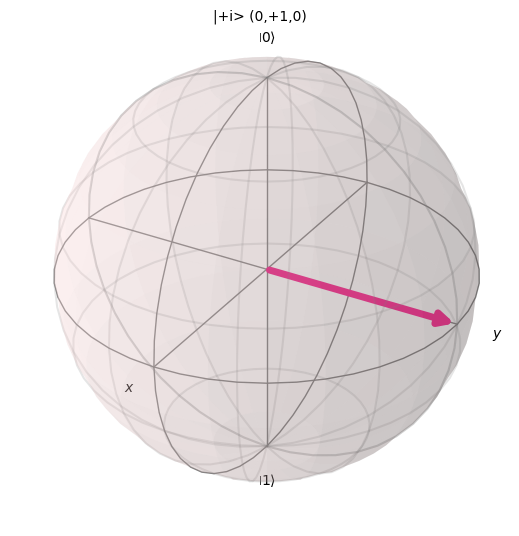

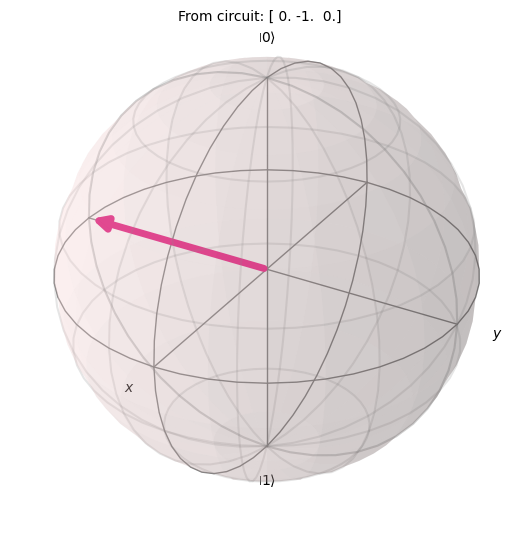

In [3]:

# Example A: principal axes
fig1 = plot_bloch_vector([0, 0, 1], title="|0>  (0,0,+1)"); display(fig1)
fig2 = plot_bloch_vector([1, 0, 0], title="|+>  (+1,0,0)"); display(fig2)
fig3 = plot_bloch_vector([0, 1, 0], title="|+i> (0,+1,0)"); display(fig3)

# Example B: from a circuit
qc = QuantumCircuit(1); qc.rx(np.pi/2, 0)
sv = Statevector.from_instruction(qc)
vec = bloch_from_statevector(sv)
fig4 = plot_bloch_vector(vec, title=f"From circuit: {np.round(vec,3)}"); display(fig4)



## 2) `plot_bloch_multivector` — per-qubit Bloch spheres from a state

- Input: a `Statevector` or `DensityMatrix` (≥1 qubit).
- Output: one sphere per qubit, visualizing each **reduced** single-qubit state.
- For **entangled** pure states (e.g., a Bell state), each qubit’s **reduced** state can be **mixed** even though the global state is pure.  
  In an **ideal** Bell state, the local reduced state is maximally mixed (ρ = I/2), so the local Bloch vector is **exactly (0,0,0)**.

> `plot_bloch_multivector` shows **points**, not arrows. A zero-length vector lives at the origin and can be hard to see; we overlay a small origin marker below.


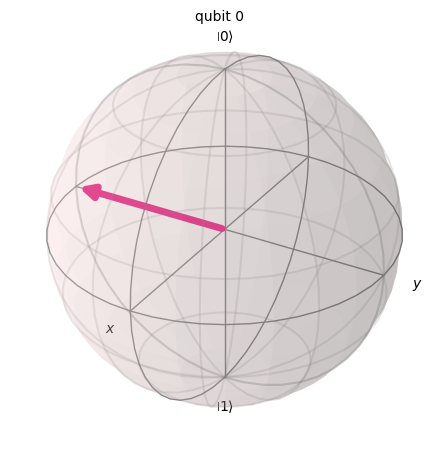

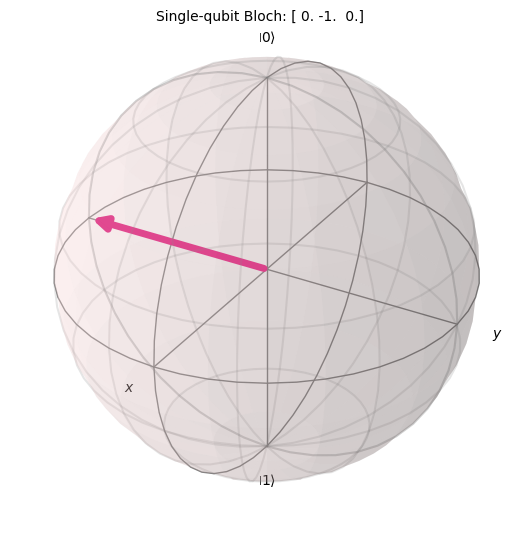

Bloch(q0) ~ [0. 0. 0.]   Bloch(q1) ~ [0. 0. 0.]


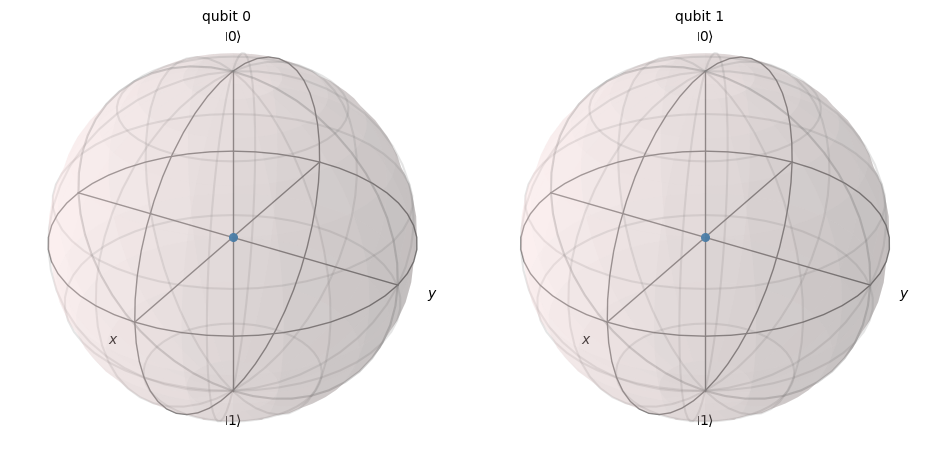

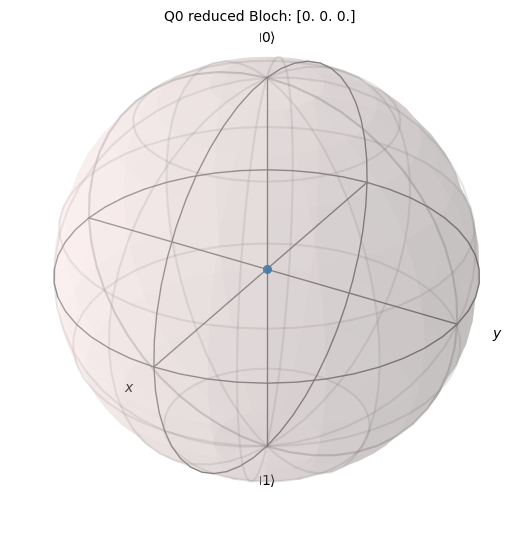

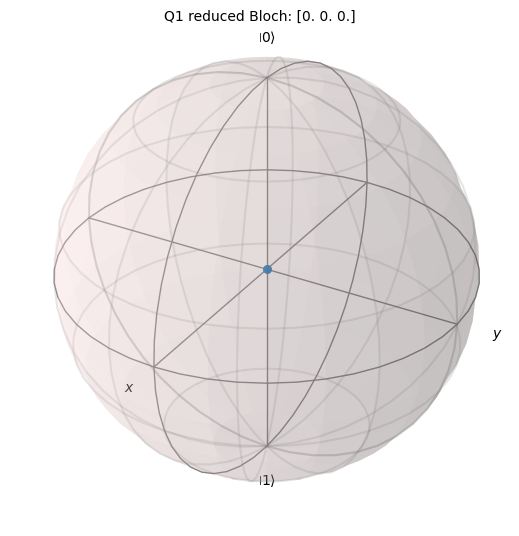

In [4]:

# Helper to mark the origin when vectors are (numerically) zero
def overlay_origin_marker(fig, tol=1e-8, vecs=None):
    import numpy as _np
    axes = fig.axes
    if vecs is None:
        for ax in axes:
            ax.scatter([0], [0], [0], s=30)
        return fig
    for (x,y,z), ax in zip(vecs, axes):
        if _np.linalg.norm([x,y,z]) < tol:
            ax.scatter([0], [0], [0], s=30)
    return fig

# Single-qubit pure state: Rx(pi/2) → (0,-1,0)
qc1 = QuantumCircuit(1); qc1.rx(np.pi/2, 0)
sv1 = Statevector.from_instruction(qc1)
fig5 = plot_bloch_multivector(sv1); display(fig5)

# Also show arrow for clarity
from_vec1 = bloch_from_statevector(sv1)
fig5b = plot_bloch_vector(list(from_vec1), title=f"Single-qubit Bloch: {np.round(from_vec1,3)}"); display(fig5b)

# Two-qubit Bell state: local vectors are exactly (0,0,0)
qc2 = QuantumCircuit(2); qc2.h(0); qc2.cx(0,1)
sv2 = Statevector.from_instruction(qc2)
fig6 = plot_bloch_multivector(sv2)

# Compute reduced single-qubit states and overlay origin markers
rho2 = DensityMatrix(sv2)
rho_q0 = partial_trace(rho2, [1])
rho_q1 = partial_trace(rho2, [0])
def bloch_from_rho(rho):
    x = float(np.real(rho.expectation_value(SparsePauliOp('X'))))
    y = float(np.real(rho.expectation_value(SparsePauliOp('Y'))))
    z = float(np.real(rho.expectation_value(SparsePauliOp('Z'))))
    return x, y, z
vec_q0 = bloch_from_rho(rho_q0)
vec_q1 = bloch_from_rho(rho_q1)
print("Bloch(q0) ~", np.round(vec_q0, 6), "  Bloch(q1) ~", np.round(vec_q1, 6))
overlay_origin_marker(fig6, vecs=[vec_q0, vec_q1]); display(fig6)

# Explicit zero-length arrows for each reduced state
fig6b = plot_bloch_vector(list(vec_q0), title=f"Q0 reduced Bloch: {np.round(vec_q0,6)}"); overlay_origin_marker(fig6b); display(fig6b)
fig6c = plot_bloch_vector(list(vec_q1), title=f"Q1 reduced Bloch: {np.round(vec_q1,6)}"); overlay_origin_marker(fig6c); display(fig6c)



## 3) `plot_state_qsphere` — amplitude & phase on the Qsphere

**What is a Qsphere?**

A Qsphere visualizes an *n*-qubit **statevector** by placing each computational basis state |z⟩ (e.g., |00⟩, |01⟩, …) as a point on a sphere:

- **Placement (geometry):** basis states are grouped by **Hamming weight** (number of 1s). States with the same weight share a latitude.
  - |00…0⟩ sits at the **north pole**; |11…1⟩ sits at the **south pole**.
  - Within a latitude, different bitstrings are spaced around longitude.
- **Dot size = probability** |α_z|²: larger dots correspond to higher measurement probability.
- **Dot color = phase** arg(α_z): hue encodes the complex phase. Global phase moves all colors together; **relative** phase differences are what matter.

**Why it’s useful:** it exposes which basis states carry probability mass (size) and how their phases are arranged (color), making superpositions and controlled‑phase patterns easy to see.


In [5]:

# Bell state qsphere
qc_qs = QuantumCircuit(2); qc_qs.h(0); qc_qs.cx(0,1)
sv_qs = Statevector.from_instruction(qc_qs)
fig7 = plot_state_qsphere(sv_qs); display(fig7)

# Additional qsphere illustrations
def show_qsphere(qc, title):
    sv = Statevector.from_instruction(qc)
    fig = plot_state_qsphere(sv)
    print(title); display(fig)

# 1) |++> : equal amplitudes and phases
qc_plus = QuantumCircuit(2); qc_plus.h(0); qc_plus.h(1)
show_qsphere(qc_plus, "Qsphere for |++>: equal sizes; uniform phase (colors aligned)")

# 2) |Φ+>: two large dots at poles with the same phase
qc_bell = QuantumCircuit(2); qc_bell.h(0); qc_bell.cx(0,1)
show_qsphere(qc_bell, "Qsphere for |Φ+>: weight on |00> and |11>; phases aligned")

# 3) Phase-kicked superposition via S on qubit 1 after |++>
qc_phase = QuantumCircuit(2); qc_phase.h(0); qc_phase.h(1); qc_phase.s(1)
show_qsphere(qc_phase, "Qsphere with relative phase: equal sizes; states with qubit-1=1 are phase-shifted")

# 4) Controlled-Z on |++>
qc_cz = QuantumCircuit(2); qc_cz.h(0); qc_cz.h(1); qc_cz.cz(0,1)
show_qsphere(qc_cz, "Qsphere with CZ: equal sizes; |11> carries a π phase (opposite hue)")


MissingOptionalLibraryError: "The 'seaborn' library is required to use 'plot_state_qsphere'. You can install it with 'pip install seaborn'."


## 4) `plot_state_hinton` — Hinton diagram of the density matrix ρ


In [ ]:

qc_pure = QuantumCircuit(1); qc_pure.h(0)
sv_pure = Statevector.from_instruction(qc_pure)

qc_bell2 = QuantumCircuit(2); qc_bell2.h(0); qc_bell2.cx(0,1)
rho_bell = DensityMatrix.from_instruction(qc_bell2)
rho_mixed_q0 = partial_trace(rho_bell, [1])

fig8 = plot_state_hinton(sv_pure); display(fig8)
fig9 = plot_state_hinton(rho_mixed_q0); display(fig9)



## 5) `plot_state_city` — “cityscape” bars for ρ (real/imag parts)


In [ ]:

fig10 = plot_state_city(sv_pure); display(fig10)
fig11 = plot_state_city(rho_mixed_q0); display(fig11)



## 6) `plot_state_paulivec` — Pauli-vector of ρ


In [ ]:

fig12 = plot_state_paulivec(sv_pure); display(fig12)
fig13 = plot_state_paulivec(Statevector.from_instruction(qc_bell2)); display(fig13)



## 7) `plot_histogram` — visualize measurement counts


In [ ]:

counts = {'0': 520, '1': 504}
fig14 = plot_histogram(counts, title="Sample counts"); display(fig14)
